# Email Classification with BERT using Kaggle Dataset

# Data Preprocessing

## Imports

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Loading & Exploaring Dataset

In [ ]:
df = pd.read_csv('emails.csv')

print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

# Data exploration
print("\nData types:")
print(df.dtypes)

print("\nMissing values:")
print(df.isnull().sum())

print("\nLabel distribution:")
print(df['spam'].value_counts())

# Feature engineering - add text length
df['text_length'] = df['text'].str.len()
print("\nText length statistics:")
print(df['text_length'].describe())

# Data cleaning
df = df.dropna(subset=['text', 'spam'])
df['text'] = df['text'].astype(str)
df['spam'] = df['spam'].astype(int)

print(f"\nCleaned dataset shape: {df.shape}")

Dataset shape: (5728, 2)
First few rows:
                                                text  spam
0  Subject: naturally irresistible your corporate...     1
1  Subject: the stock trading gunslinger  fanny i...     1
2  Subject: unbelievable new homes made easy  im ...     1
3  Subject: 4 color printing special  request add...     1
4  Subject: do not have money , get software cds ...     1
Data types:
text    object
spam     int64
dtype: object
Missing values:
text    0
spam    0
dtype: int64
Label distribution:
spam
0    4360
1    1368
Name: count, dtype: int64
Text length statistics:
count     5728.000000
mean      1556.768680
std       2042.649812
min         13.000000
25%        508.750000
50%        979.000000
75%       1894.250000
max      43952.000000
Name: text_length, dtype: float64
Cleaned dataset shape: (5728, 3)


## Tokenization & Cleaning of Texts

In [ ]:
def prepare_data(texts, labels, tokenizer, max_length=256):
    cleaned_texts = []
    for text in texts:
        text = str(text).strip()
        text = ' '.join(text.split())
        cleaned_texts.append(text)

    encodings = tokenizer(
        cleaned_texts,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

    dataset = torch.utils.data.TensorDataset(
        encodings['input_ids'],
        encodings['attention_mask'],
        torch.tensor(labels, dtype=torch.long)
    )

    return dataset

# Model Architecture

In [ ]:
class BERTSpamClassifier(nn.Module):
    def __init__(self, model_name='distilbert-base-uncased', num_classes=2, dropout_rate=0.3):
        super(BERTSpamClassifier, self).__init__()

        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)

        hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size // 2, num_classes)
        )

        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

# Training & Evaluation functions

Using device: cuda
Dataset shape: (5728, 2)
First few rows:
                                                text  spam
0  Subject: naturally irresistible your corporate...     1
1  Subject: the stock trading gunslinger  fanny i...     1
2  Subject: unbelievable new homes made easy  im ...     1
3  Subject: 4 color printing special  request add...     1
4  Subject: do not have money , get software cds ...     1
Data types:
text    object
spam     int64
dtype: object
Missing values:
text    0
spam    0
dtype: int64
Label distribution:
spam
0    4360
1    1368
Name: count, dtype: int64
Text length statistics:
count     5728.000000
mean      1556.768680
std       2042.649812
min         13.000000
25%        508.750000
50%        979.000000
75%       1894.250000
max      43952.000000
Name: text_length, dtype: float64
Cleaned dataset shape: (5728, 3)
Model: distilbert-base-uncased
Max Length: 128
Batch Size: 128
Epochs per fold: 3


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


FOLD 1/5
Train size: 4582 (Spam: 1094)
Val size: 1146 (Spam: 274)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Fold 1 Epoch 1:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.6580, Val Accuracy: 0.8656, Val F1: 0.8448


Fold 1 Epoch 2:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.1639, Val Accuracy: 0.9616, Val F1: 0.9609


Fold 1 Epoch 3:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.0764, Val Accuracy: 0.9729, Val F1: 0.9726
Fold 1 Best Accuracy: 0.9729

FOLD 2/5
Train size: 4582 (Spam: 1094)
Val size: 1146 (Spam: 274)


Fold 2 Epoch 1:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.4212, Val Accuracy: 0.9459, Val F1: 0.9442


Fold 2 Epoch 2:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.1168, Val Accuracy: 0.9756, Val F1: 0.9755


Fold 2 Epoch 3:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.0625, Val Accuracy: 0.9834, Val F1: 0.9834
Fold 2 Best Accuracy: 0.9834

FOLD 3/5
Train size: 4582 (Spam: 1094)
Val size: 1146 (Spam: 274)


Fold 3 Epoch 1:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.5469, Val Accuracy: 0.8979, Val F1: 0.8892


Fold 3 Epoch 2:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.1598, Val Accuracy: 0.9511, Val F1: 0.9496


Fold 3 Epoch 3:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.0848, Val Accuracy: 0.9686, Val F1: 0.9682
Fold 3 Best Accuracy: 0.9686

FOLD 4/5
Train size: 4583 (Spam: 1095)
Val size: 1145 (Spam: 273)


Fold 4 Epoch 1:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.5086, Val Accuracy: 0.9197, Val F1: 0.9140


Fold 4 Epoch 2:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.1510, Val Accuracy: 0.9642, Val F1: 0.9643


Fold 4 Epoch 3:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.0762, Val Accuracy: 0.9738, Val F1: 0.9737
Fold 4 Best Accuracy: 0.9738

FOLD 5/5
Train size: 4583 (Spam: 1095)
Val size: 1145 (Spam: 273)


Fold 5 Epoch 1:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.5592, Val Accuracy: 0.9258, Val F1: 0.9215


Fold 5 Epoch 2:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.1537, Val Accuracy: 0.9703, Val F1: 0.9700


Fold 5 Epoch 3:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.0816, Val Accuracy: 0.9790, Val F1: 0.9790
Fold 5 Best Accuracy: 0.9790

CROSS VALIDATION RESULTS
Mean Accuracy: 0.9756 ± 0.0051
Overall F1 Score: 0.9754
Individual Fold Accuracies: ['0.9729', '0.9834', '0.9686', '0.9738', '0.9790']

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.99      0.98      4360
        Spam       0.97      0.93      0.95      1368

    accuracy                           0.98      5728
   macro avg       0.97      0.96      0.97      5728
weighted avg       0.98      0.98      0.98      5728



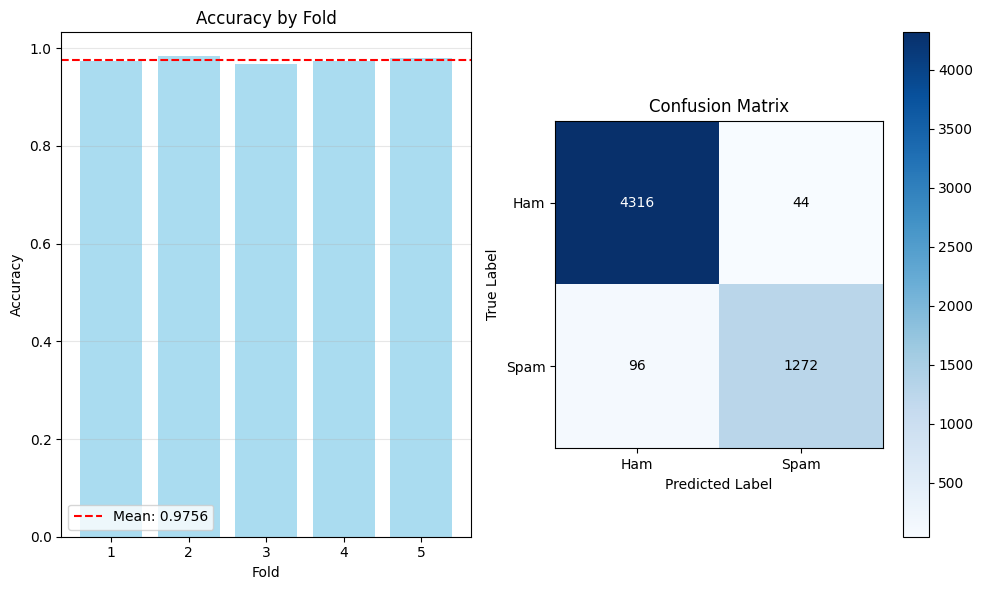

Training Epoch 1:   0%|          | 0/287 [00:00<?, ?it/s]

Training Epoch 2:   0%|          | 0/287 [00:00<?, ?it/s]

Training Epoch 3:   0%|          | 0/287 [00:00<?, ?it/s]

Training Epoch 4:   0%|          | 0/287 [00:00<?, ?it/s]


Final Model Performance:
Test Accuracy: 0.9878
Test F1 Score: 0.9878
Model saved as 'spam_classifier.pth'

Testing classifier:
Email: Congratulations! You've won $1000! Click here now!...
Prediction: Spam (Confidence: 1.000)

Email: Hi John, please find the attached report for revie...
Prediction: Ham (Confidence: 1.000)



In [ ]:
def train_fold(model, train_loader, val_loader, fold_num, epochs=3):
    optimizer = AdamW([
        {'params': model.bert.parameters(), 'lr': 1e-5},
        {'params': model.classifier.parameters(), 'lr': 2e-5}
    ], weight_decay=0.01)

    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=total_steps // 10,
        num_training_steps=total_steps
    )

    criterion = nn.CrossEntropyLoss()
    best_val_accuracy = 0

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        train_bar = tqdm(train_loader, desc=f"Fold {fold_num+1} Epoch {epoch+1}")
        for batch in train_bar:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()
            train_bar.set_postfix({'loss': loss.item()})

        model.eval()
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids, attention_mask)
                predictions = torch.argmax(outputs, dim=1)

                val_predictions.extend(predictions.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_predictions)
        val_f1 = f1_score(val_labels, val_predictions, average='weighted')

        print(f"Epoch {epoch+1}: Train Loss: {total_train_loss/len(train_loader):.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy

    return best_val_accuracy, val_predictions, val_labels

def cross_validate(df, n_folds=5):
    MODEL_NAME = 'distilbert-base-uncased'
    MAX_LENGTH = min(128, int(df['text_length'].quantile(0.95)))
    BATCH_SIZE = 128
    EPOCHS = 3

    print(f"Model: {MODEL_NAME}")
    print(f"Max Length: {MAX_LENGTH}")
    print(f"Batch Size: {BATCH_SIZE}")
    print(f"Epochs per fold: {EPOCHS}")

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    texts = df['text'].values
    labels = df['spam'].values

    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    fold_results = []
    all_predictions = []
    all_true_labels = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
        print(f"\nFOLD {fold + 1}/{n_folds}")

        train_texts = texts[train_idx]
        train_labels = labels[train_idx]
        val_texts = texts[val_idx]
        val_labels = labels[val_idx]

        print(f"Train size: {len(train_texts)} (Spam: {sum(train_labels)})")
        print(f"Val size: {len(val_texts)} (Spam: {sum(val_labels)})")

        train_dataset = prepare_data(train_texts, train_labels, tokenizer, MAX_LENGTH)
        val_dataset = prepare_data(val_texts, val_labels, tokenizer, MAX_LENGTH)

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

        model = BERTSpamClassifier(MODEL_NAME, num_classes=2, dropout_rate=0.3).to(device)

        fold_accuracy, fold_preds, fold_labels = train_fold(
            model, train_loader, val_loader, fold, EPOCHS
        )

        fold_results.append(fold_accuracy)
        all_predictions.extend(fold_preds)
        all_true_labels.extend(fold_labels)

        print(f"Fold {fold + 1} Best Accuracy: {fold_accuracy:.4f}")

        del model
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    mean_accuracy = np.mean(fold_results)
    std_accuracy = np.std(fold_results)
    overall_f1 = f1_score(all_true_labels, all_predictions, average='weighted')

    print(f"\nCROSS VALIDATION RESULTS")
    print(f"Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"Overall F1 Score: {overall_f1:.4f}")
    print(f"Individual Fold Accuracies: {[f'{acc:.4f}' for acc in fold_results]}")

    print(f"\nClassification Report:")
    print(classification_report(all_true_labels, all_predictions,
                              target_names=['Ham', 'Spam']))

    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.bar(range(1, n_folds + 1), fold_results, color='skyblue', alpha=0.7)
    plt.axhline(y=mean_accuracy, color='red', linestyle='--',
                label=f'Mean: {mean_accuracy:.4f}')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy by Fold')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    cm = confusion_matrix(all_true_labels, all_predictions)
    plt.subplot(1, 2, 2)
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks([0, 1], ['Ham', 'Spam'])
    plt.yticks([0, 1], ['Ham', 'Spam'])

    plt.tight_layout()
    plt.show()

    return fold_results, mean_accuracy, tokenizer

fold_accuracies, final_accuracy, trained_tokenizer = cross_validate(df, n_folds=5)

def train_final_model(df, tokenizer):
    MODEL_NAME = 'distilbert-base-uncased'
    MAX_LENGTH = min(256, int(df['text_length'].quantile(0.95)))

    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['spam'], random_state=42)

    train_dataset = prepare_data(train_df['text'].values, train_df['spam'].values,
                                       tokenizer, MAX_LENGTH)
    test_dataset = prepare_data(test_df['text'].values, test_df['spam'].values,
                                      tokenizer, MAX_LENGTH)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    final_model = BERTSpamClassifier(MODEL_NAME, num_classes=2).to(device)

    optimizer = AdamW([
        {'params': final_model.bert.parameters(), 'lr': 1e-5},
        {'params': final_model.classifier.parameters(), 'lr': 2e-5}
    ], weight_decay=0.01)

    criterion = nn.CrossEntropyLoss()

    final_model.train()
    for epoch in range(4):
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            optimizer.zero_grad()
            outputs = final_model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(final_model.parameters(), max_norm=1.0)
            optimizer.step()

    final_model.eval()
    test_predictions = []
    test_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = final_model(input_ids, attention_mask)
            predictions = torch.argmax(outputs, dim=1)

            test_predictions.extend(predictions.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    final_test_accuracy = accuracy_score(test_labels, test_predictions)
    final_f1 = f1_score(test_labels, test_predictions, average='weighted')

    print(f"\nFinal Model Performance:")
    print(f"Test Accuracy: {final_test_accuracy:.4f}")
    print(f"Test F1 Score: {final_f1:.4f}")

    torch.save({
        'model_state_dict': final_model.state_dict(),
        'tokenizer_name': MODEL_NAME,
        'max_length': MAX_LENGTH,
        'accuracy': final_test_accuracy
    }, 'spam_classifier.pth')

    print(f"Model saved as 'spam_classifier.pth'")

    return final_model, final_test_accuracy

final_model, test_accuracy = train_final_model(df, trained_tokenizer)

# Model Inferencing

In [ ]:
def load_classifier():
    checkpoint = torch.load('spam_classifier.pth', map_location=device)
    tokenizer = AutoTokenizer.from_pretrained(checkpoint['tokenizer_name'])

    model = BERTSpamClassifier(checkpoint['tokenizer_name'])
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    return model, tokenizer, checkpoint['max_length']

def predict_email(text, model, tokenizer, max_length):
    text = str(text).strip()
    encoding = tokenizer(text, truncation=True, padding='max_length',
                        max_length=max_length, return_tensors='pt')

    with torch.no_grad():
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask)
        probs = torch.softmax(outputs, dim=1)
        pred = torch.argmax(probs, dim=1).item()
        conf = probs[0][pred].item()

    return {
        'result': 'Spam' if pred == 1 else 'Ham',
        'confidence': conf,
        'spam_score': probs[0][1].item()
    }

model, tokenizer, max_length = load_classifier()

# Diverse test cases (15 examples)
examples = [
    # Clear Spam (Financial Scams)
    "CONGRATULATIONS! You've won $50,000 in our lottery! Click here to claim your prize immediately!",
    "URGENT: Your account will be suspended unless you verify your details within 24 hours!",
    "You've been pre-approved for a $10,000 loan with 0% interest! Apply now before offer expires!",

    # Phishing Attempts
    "Your Amazon order #AMZ-7449 for $899.99 has been shipped. Click to track or cancel.",
    "Security Alert: Unusual activity detected on your Google account. Verify identity now.",
    "Your PayPal account has been limited. Click here to restore access immediately.",

    # Clear Ham (Work/Personal)
    "Hi Sarah, please find attached the quarterly financial report for Q3 2024. Let me know if any questions.",
    "Meeting reminder: Team standup tomorrow at 10 AM in Conference Room B. See you there!",
    "Thanks for helping me move last weekend. I owe you dinner! How about next Friday?",
    "Your flight UA 1234 from LAX to JFK departs at 8:45 AM on March 15th. Have a safe trip!",

    # Borderline Cases (Legitimate Marketing)
    "Limited time offer: 50% off all items! Use code SAVE50 at checkout. Valid until Sunday.",
    "Free webinar: Learn advanced Excel techniques. Register now - only 100 spots available!",
    "Your warranty is about to expire. Extend your coverage for 3 more years at discounted price.",

    # Legitimate Notifications
    "Reminder: Your library books are due tomorrow. Renew online to avoid late fees.",
    "Newsletter: This week's top tech news and startup funding updates. Unsubscribe anytime."
]

print("Email Classification Results:")
print("-" * 60)

for i, email in enumerate(examples, 1):
    result = predict_email(email, model, tokenizer, max_length)

    indicator = "SPAM" if result['result'] == 'Spam' else "HAM "

    print(f"{i:2}. [{indicator}] {result['confidence']:.3f} - {email[:55]}...")

print("-" * 60)


Email Classification Results:
------------------------------------------------------------
 1. [SPAM] 1.000 - CONGRATULATIONS! You've won $50,000 in our lottery! Cli...
 2. [SPAM] 1.000 - URGENT: Your account will be suspended unless you verif...
 3. [SPAM] 1.000 - You've been pre-approved for a $10,000 loan with 0% int...
 4. [SPAM] 1.000 - Your Amazon order #AMZ-7449 for $899.99 has been shippe...
 5. [SPAM] 1.000 - Security Alert: Unusual activity detected on your Googl...
 6. [SPAM] 1.000 - Your PayPal account has been limited. Click here to res...
 7. [HAM ] 1.000 - Hi Sarah, please find attached the quarterly financial ...
 8. [HAM ] 1.000 - Meeting reminder: Team standup tomorrow at 10 AM in Con...
 9. [HAM ] 0.995 - Thanks for helping me move last weekend. I owe you dinn...
10. [HAM ] 0.906 - Your flight UA 1234 from LAX to JFK departs at 8:45 AM ...
11. [SPAM] 1.000 - Limited time offer: 50% off all items! Use code SAVE50 ...
12. [SPAM] 1.000 - Free webinar: Learn advanced Exc